In [1]:
import numpy as np
import descent
import matplotlib.pyplot as plt
try:
    from ipywidgets import interact
except ImportError:
    from IPython.html.widgets import interact

plt.style.use(['ocean', 'seaborn-notebook'])
%matplotlib inline

# Introduction to the descent package

Let's say we want to optimize the following:

$$ \text{minimize}\quad f(x) $$

given a computable expression for $f(x)$ and $\nabla f(x)$.

## Organization

Descent contains a number of agorithms that can be used to perform unconstrained and constrained optimization. These algorithms are split into two types, the _first-order gradient-based algorithms_ and _proximal algorithms_.

Proximal algorithms:
- Proximal Consensus / Alternating direction method of multipliers (ADMM)
- Proximal gradient descent
- Accelerated proximal gradient descent

First-order gradient-based algorithms:
- Gradient descent (can be stochastic, with or without momentum)
- [Stochastic average gradient (SAG)](http://arxiv.org/abs/1309.2388)
- RMSProp
- [Adam](http://arxiv.org/abs/1412.6980)


## Toy example

For an introductory example, consider the following toy function (a quadratic):
$$ f(x) = \frac{1}{2} x^Tx $$

In [2]:
# quadratic in n-dimensions
def f_df(x):
    objective = 0.5 * x.T.dot(x)
    gradient = x
    return objective, gradient

In [3]:
# initial guess
x0 = np.random.randn(10)

In [4]:
# optimize with gradient descent
learning_rate = 0.1
optimizer = descent.GradientDescent(x0, f_df, 'sgd', {'lr': learning_rate})
optimizer.run(maxiter=100)

The learned parameters are stored in the `theta` property:

In [5]:
optimizer.theta

array([ -1.58163754e-05,   2.13525933e-05,  -2.47031058e-05,
        -5.02514712e-05,   1.31953820e-06,   1.43428226e-05,
        -6.25972993e-05,  -2.53576341e-05,  -4.84312426e-07,
        -1.36355765e-05])

By default, the objective function at every iteration is stored in a list, and accessed through the `store` property:

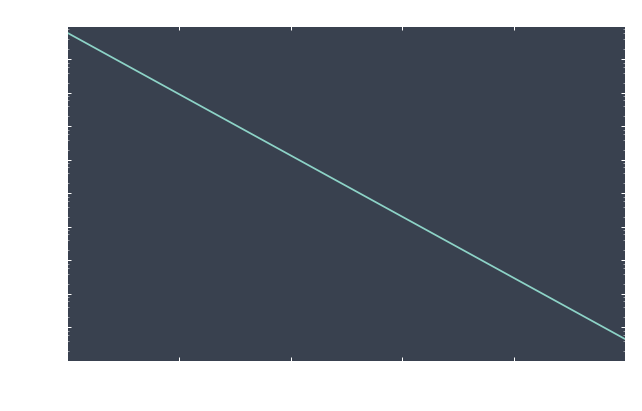

In [6]:
plt.figure(figsize=(10,6))
plt.semilogy(optimizer.store['objective'])
plt.xlabel('Iteration, $k$', fontsize=20)
plt.ylabel('Objective $f(x^k)$', fontsize=20)
plt.title('Linear convergence of gradient descent', fontsize=18)

## Proximal operators

See the `descent.proximal_operators` module

For example, here is the proximal operator for the $\ell_1$-norm, with $\lambda = 0.1$ (the soft thresholding function):

In [7]:
# get the proximal operator
proxop = descent.proxops.sparse(0.1)

# this returns a callable object that evaluates the proximal operator given a starting location and a value for rho:
# apply it to a random value, with a given value of rho
x = np.arange(5)
print('Input: ', x)
rho = 1
print('After applying the prox. op.:', proxop(x, rho))

Input:  [0 1 2 3 4]
After applying the prox. op.: [ 0.   0.9  1.9  2.9  3.9]


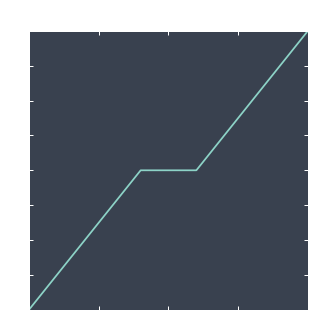

In [8]:
# explore the impact of the penalty parameter
@interact(penalty=(0.01, 0.5, 0.05))
def plot_prox(penalty=0.1):

    # get the proximal operator
    proxop = descent.proxops.sparse(penalty)
    
    # set the value of rho
    rho = 0.05
    
    x = np.linspace(-10,10,1e3)
    y = proxop(x, rho)

    plt.figure(figsize=(5,5))
    plt.title('$\lambda = {}$'.format(penalty), fontsize=24)
    plt.plot(x,y)

Here is another example, the proximal operator for the nuclear norm (penalty encourages low-rank solutions):

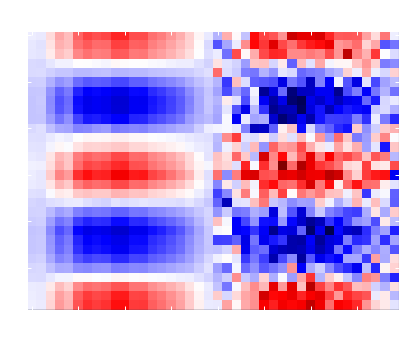

In [9]:
# apply it to a matrix
u = np.cos(4*np.linspace(0,np.pi,30))
v = np.sin(np.linspace(0,np.pi,20))
X = np.outer(u, v) + 0.3 * np.random.randn(30,20)
rho = 1.

@interact(penalty=(0.0, 5.0, 0.5))
def plot_prox(penalty=0.05):

    proxop = descent.proxops.nucnorm(penalty)
    X_lr = proxop(X, rho)

    plt.figure(figsize=(10,5))
    plt.title('$\lambda = {}$'.format(penalty), fontsize=24)
    plt.imshow(np.hstack([X_lr, X]), aspect='equal', cmap='seismic', interpolation='none')
    plt.xlabel('Prox. update        Original image', fontsize=20)